# CSE 204 Lab 11: Unsupervised Learning - Clustering

J.B. Scoggins

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jbscoggi/teaching/blob/master/Polytechnique/CSE204/Lab11_answers.ipynb) 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jbscoggi/teaching/master?filepath=Polytechnique%2FCSE204%2FLab11_answers.ipynb)

## Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

### Datasets

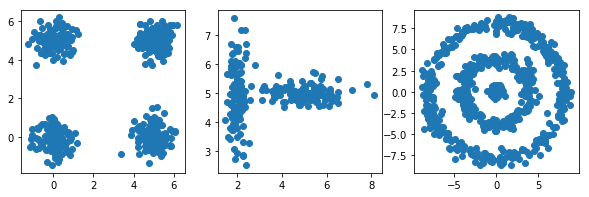

In [7]:
# Create a data set
N = 120

data1 = np.random.normal((0,0), (0.5,0.5) ,size=(N,2))
data1 = np.append(data1, np.random.normal((5,0), (0.5,0.5), size=(N,2)), axis=0)
data1 = np.append(data1, np.random.normal((0,5), (0.5,0.5), size=(N,2)), axis=0)
data1 = np.append(data1, np.random.normal((5,5), (0.5,0.5), size=(N,2)), axis=0)

data2 = np.random.normal((2,5), (0.25, 1), size=(N,2))
data2 = np.append(data2, np.random.normal((5,5), (1, 0.25), size=(N,2)), axis=0)

radii = np.random.normal(0,0.5,size=(N,1))
radii = np.append(radii, np.random.normal(4,0.5,size=(2*N,1)), axis=0)
radii = np.append(radii, np.random.normal(8,0.5,size=(3*N,1)), axis=0)
angles = np.random.uniform(size=(6*N,1))*2.0*np.pi
data3 = np.hstack([radii*np.cos(angles), radii*np.sin(angles)])

data_sets = [data1, data2, data3]

fig, axes = plt.subplots(1,len(data_sets), figsize=(10,3))
for i,data in enumerate(data_sets):
    axes[i].scatter(data[:,0], data[:,1])

## Step 1: The k-Means Algorithm

k-means is one of the simplest unsupervised learning algorithms that solves the well known clustering problem. The algorithm defines an iterative process, where the following two steps take part at each iteration:
1. take each instance belonging to the dataset and assign it to the nearest centroid, and
2. re-calculate the centroids of each of the k clusters. 
Thus, the k centroids change their location step by step until no more changes are done.

More formally, suppose that we are given a dataset $X = \{x_1, x_2, \dots , x_m\}$, where each $x_i \in \mathbb{R}^n$. The goal of the k-means algorithm is to group the data into k cohesive clusters, where k is an input parameter of the algorithm. Algorithm 1 gives the pseudocode of k-means.

___
### Algorithm 1: k-means

**Input**: Dataset $\mathbf{X} = \{x_1, x_2, \dots, x_m\}$, where each $x_i \in \mathbb{R}^n$ and parameter $k$ <br>
**Output**: Clusters $\mathbf{C}_1, \mathbf{C}_2, \ldots, \mathbf{C}_k$ (i.e., cluster assignments of each instance $C = \{c_1, c_2, \ldots, c_m\}$)

1. Initialize cluster centroids $\mathbf{\mu}_1, \mathbf{\mu}_2, \ldots, \mathbf{\mu}_k$ by choosing $k$ instances of $\mathbf{X}$ randomly

**repeat**
2. Assign each instance $\mathbf{x}_i \in \mathbf{X}$ to the closest centroid, i.e., $c_i = \text{argmin}_j \|\mathbf{x}_i - \mathbf{\mu}_j\|$
3. Re-compute the centroids $\mathbf{\mu}_1, \mathbf{\mu}_2, \ldots, \mathbf{\mu}_k$ of each cluster based on $\mathbf{\mu}_j = (\sum_{\mathbf{x} \in \mathbf{C}_j} \mathbf{x})/|\mathbf{C}_j|$, where $\mathbf{C}_j, j=1, \ldots, k$ the $j$-th cluster and  $|\mathbf{C}_j|$ the size of the $j$-th cluster

**until** Centroids do not change (convergence)
___

In the algorithm above, k is a parameter of the algorithm and corresponds to the number of clusters we want to find; the cluster centroids μj represent our current guesses for the positions of the centers of the clusters. To initialize the cluster centroids (in step 1 of the algorithm), we could choose k training ex- amples randomly, and set the cluster centroids to be equal to the values of these k examples. Of course, other initialization methods are also possible, such as the [kmeans++ technique](https://en.wikipedia.org/wiki/K-means%2B%2B). To find the closest centroid, a distance (or similarity) function should be defined, and typically the Euclidean distance is used.

Based on this notion of similarity, the problem of clustering can be reduced to the problem of finding appropriate centroids. This, in turn, can be expressed as the task of minimizing the following objective function:
$$
E(k) = \sum_{j=1}^{k} \sum_{\mathbf{x}_i \in \mathbf{C}_j}\| \mathbf{x}_i - \mathbf{\mu}_j \|.
$$

Thus, minimizing the above function is to determine suitable centroids $\mathbf{\mu}_j$ such that, if the data is partitioned into corresponding clusters $\mathbf{C}_j$, distances between data points and their closest cluster centroid become as small as possible.

The convergence of k-means algorithm is highly dependent on the initialization of the centroids. Although the algorithm can converge, this may be to a local minimum of the objective function above. One way to overcome this problem is by executing the algorithm several times, with different initializations of the centroids. 

Another issue is how to set parameter $k$, i.e., how to determine the number of clusters of the dataset. Intuitively,  increasing $k$ without penalty, will always reduce the amount of error in the resulting clustering, to the extreme case of zero error if each data point is considered its own cluster (i.e., when $k$ equals the number of data points, $m$). One such method is known as the [elbow rule](http://www.mattpeeples.net/kmeans.html). The idea is to examine  and compare the sum of squared error (SSE) given above for a number of cluster solutions.  In general, as the number of clusters increases, the SSE should decrease because clusters are, by definition, smaller. A plot of the SSE against a series of sequential cluster levels (i.e., different values) can be helpful here. That is, an appropriate cluster solution could be defined as the one where the reduction in SSE slows dramatically. This produces an "elbow" in the plot of SSE against the different values of $k$. 

In [8]:
def euclidean_distance(X1, X2):
    """Computes the Euclidean distance between two arrays of points."""
    distance = np.zeros((X1.shape[0], X2.shape[0]))
    for i in range(X1.shape[0]):
        for k in range(X2.shape[0]):
            distance[i,k] = np.sum(np.square(X1[i,:]-X2[k,:]))
    return np.sqrt(distance)


def k_means(X, K):
    # Start with k random means
    indices = []
    for k in range(K):
        r = randrange(X.shape[0])
        while r in indices:
            r = r = randrange(X.shape[0])
        indices.append(r)
    means = X[indices,:]
    
    z = np.zeros((X.shape[0], K))
    z_last = np.ones((X.shape[0], K))
    
    iters = 0
    while np.sum(np.abs(z - z_last)) > 0:
        z_last = z
        iters += 1
        
        # Compute distances
        distance = euclidean_distance(X, means)
        
        # Label the points
        z = np.zeros((X.shape[0], K))
        argmin = np.argmin(distance,axis=1)
        for i in range(z.shape[0]):
            z[i,argmin[i]] = 1

        # Compute new averages
        means = np.matmul(z.T, X)
        zsum = np.sum(z, axis=0)
        for i in range(means.shape[0]):
            means[i,:] /= zsum[i] + 1.0e-10
        
    return z, iters

5
4
24
4
8
10
13
13
12


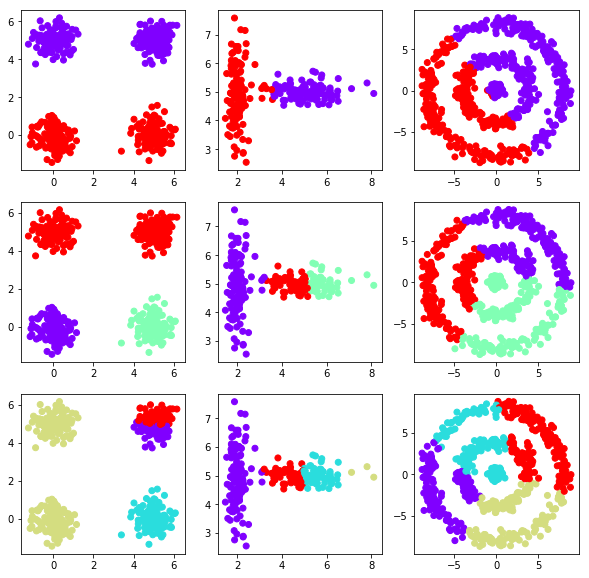

In [9]:
fig, axes = plt.subplots(3,len(data_sets),figsize=(10,10))
for i,k in enumerate([2,3,4]):
    for j,data in enumerate(data_sets):
        labels, iters = k_means(data,k)
        axes[i,j].scatter(data[:,0], data[:,1], c=np.argmax(labels, axis=1), cmap='rainbow')
        print(iters)

### Spectral k-Means

In [10]:
def spectral_k_means(X, K, N):
    closest_neighbors = np.argsort(euclidean_distance(X,X),axis=1)[:,:N]
    W = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        W[i,closest_neighbors[i,:]] = 1
        W[closest_neighbors[i,:],i] = 1
    
    D = np.diag(np.sum(W, axis=0))
    L = D - W
    eig_vals, eig_vecs = np.linalg.eig(L)
    idx = eig_vals.real.argsort()
    return k_means(eig_vecs.real[:,idx[:K]], K)
    

3
3
9
3
6
3
2
12
5


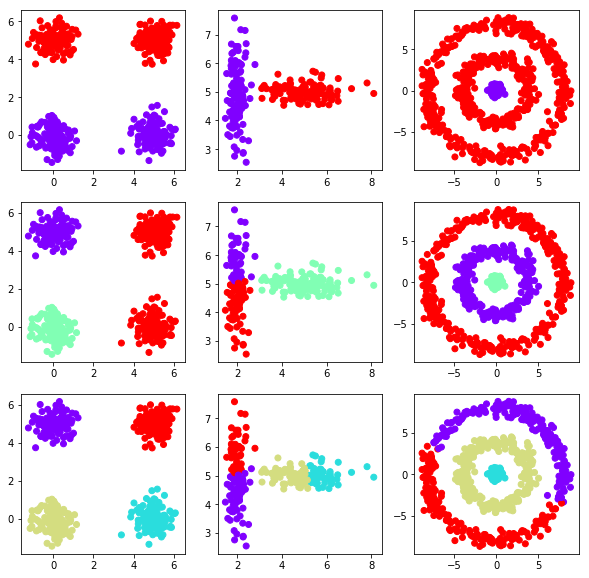

In [11]:
fig, axes = plt.subplots(3,len(data_sets), figsize=(10,10))
for i,k in enumerate([2,3,4]):
    for j,data in enumerate(data_sets):
        labels, iters = spectral_k_means(data,k,20)
        axes[i,j].scatter(data[:,0], data[:,1], c=np.argmax(labels, axis=1), cmap='rainbow')
        print(iters)